# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from tqdm import tqdm
from wpca import PCA, WPCA, EMPCA
import matplotlib
import pacmap
import random
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from astropy.io import fits
from scipy import stats
import lmfit # source: https://lmfit.github.io/lmfit-py/
from lmfit import minimize, Parameters, fit_report
from astropy import constants
import multiprocessing
from astropy.stats import sigma_clip
import time
import os
import colorednoise as cn
from scipy.stats.stats import pearsonr 

# Do some stats to simulate accurately

In [3]:
p1 = fits.open('/media/paul/One Touch11/wapiti_workflow/lblrv/EV_LAC_EV_LAC/2513265o_pp_e2dsff_tcorr_AB_EV_LAC_EV_LAC_lbl.fits') #### PATH TO CHANGE ####
wave_start, wave_end = p1[1].data['WAVE_START'], p1[1].data['WAVE_END']
depth = -p1[1].data['LINE_DEPTH']
wavelength_length = wave_end - wave_start
templates = fits.open('/media/paul/One Touch11/UdeM/lbl_spirou/templates/Template_s1dv_EV_LAC_sc1d_v_file_AB.fits')
tempwave = templates[1].data['wavelength']
tempflux = templates[1].data['flux']

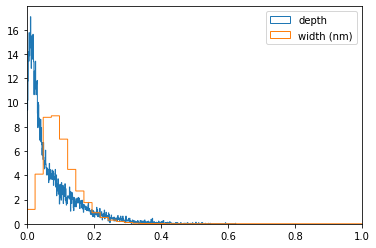

In [4]:
distribdepth = plt.hist(depth,  range = (0, np.max(depth)), histtype='step', bins = 600, label = 'depth', density = True)
distriblength = plt.hist(wavelength_length, range = (0, np.max(wavelength_length)), histtype='step', bins = 600, density = True, label = 'width (nm)')
plt.legend()
plt.xlim(0, 1)
plt.show()

In [5]:
## load identification mask
mask_W, mask_S, mask_D, mask_G  = np.loadtxt('/media/paul/One Touch11/SPIRou_Data/0.7.282/EV_Lac/mask/marcs_t3500g50_all',
                   usecols=(0,1,2,4),skiprows=1, dtype=str, unpack=True)

mask_W = np.array(mask_W.astype(float))
mask_S = np.array(mask_S.astype(float))
mask_D = np.array(mask_D.astype(float))
mask_G = np.array(mask_G.astype(float))

In [6]:
mask_G

array([ 1.4 ,  1.35,  1.24, ..., 99.  ,  1.98, 99.  ])

In [7]:
for k in range(len(mask_G)):
    if mask_G[k]==99.:
        mask_G[k] = np.nan

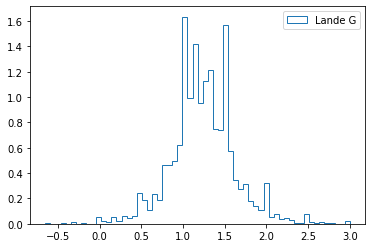

In [8]:
distriblande = plt.hist(mask_G, histtype='step', bins = 60, density = True, label = 'Lande G')
plt.legend()
plt.show()

In [9]:
binsize = tempwave[1:-1]-tempwave[0:-2]

In [10]:
np.mean(binsize)

0.005223897327228094

## Here are the useful stats

In [11]:
# KDE PDF
kde_depth  = stats.gaussian_kde(depth)
kde_length = stats.gaussian_kde(wavelength_length)
# Lande G stats 
mean_lande = np.nanmean(mask_G)
std_lande = np.nanstd(mask_G)

speed_of_light_ms = constants.c.value

## Load Activity variations

In [12]:
## Time grid
# here I use the same time sampling as EV Lac's SPIRou data to have a realistic time sampling 
# with the window function issue that come with it but feel free to set up your own time grid
target = 'EV_Lac'

time_grid, GP, BERV  = np.load('/home/paul/Bureau/IRAP/dLWPCA/SPCAndie/V_5_0/' + target + '_T_B_Berv.npy')

GP -= np.mean(GP)
#GP = GP/np.max(np.abs(GP)) #Normalize the injected signal 

Prot = 4.3615

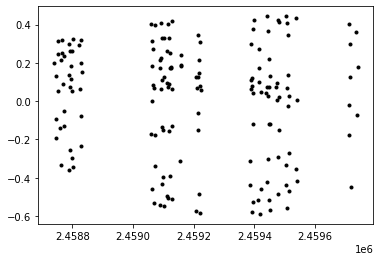

In [13]:
plt.plot(time_grid, GP, 'k.')


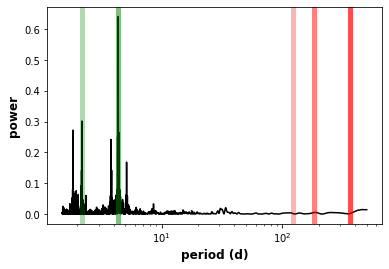

In [14]:
frequency, power = LombScargle(time_grid, GP).autopower(minimum_frequency=1/500, maximum_frequency=1/1.5)
plt.plot(1/frequency, power, 'k')
plt.ylabel("power", size=12, weight='bold')
plt.xlabel("period (d)", size=12, weight='bold')
plt.xscale('log')
plt.axvline(365.25, color='r', alpha=0.7, linewidth=5)
plt.axvline(365.25/2, color='r', alpha=0.5, linewidth=5)
plt.axvline(365.25/3, color='r', alpha=0.3, linewidth=5)
plt.axvline(Prot, color='g', alpha=0.5, linewidth=5)
plt.axvline(Prot/2, color='g', alpha=0.3, linewidth=5)

# The Model ! 
## functions, class and methods

In [15]:
def Gauss(x, a, sigma):
    return 1 - a * np.exp(-x**2 / (2 * sigma**2))    
    

def width_variation(B, g, l0):
    """
    Calculate the width variation from the zeeman effect
    
    Parameters
    ----------
    
    B: float
        > Magnetic Field in kG   
    g: float
        > Landé G factor (sensitivity to the magnetic field)
    l0: float
        > Wavelength in µm
        
    Returns
    -------
    dl: float
        > shift of the zeeman components in nm
    """
    dl = 46.67*l0*l0*g*B
    return dl/10000

def bouchy_equation(params, d2, diff, x):

    d2v = params.get('d2v').value
    zero = d2v*d2*x*x - diff
    return(zero)

def doppler_shift(wavegrid: np.ndarray, velocity: float) -> np.ndarray:
    """
    Apply a dopplershift
    
    :param wavegrid: wave grid to shift
    :param velocity: float, velocity expressed in m/s
    
    :return: np.ndarray, the updated wave grid
    """
    # relativistic calculation (1 - v/c)
    part1 = 1 - (velocity * 1000 / speed_of_light_ms)
    # relativistic calculation (1 + v/c)
    part2 = 1 + (velocity * 1000 / speed_of_light_ms)
    # return updated wave grid
    return wavegrid * np.sqrt(part1 / part2)

In [16]:
## Delta_B = ??? - 4.59 # Mag field of EV Lac
x = np.arange(-0.8, 0.8, 0.005)
SNR = 95

class Line:
    def __init__(self):
        # line primary properties
        self._landeg = np.random.normal(mean_lande, std_lande)
        self._lambdo = np.random.uniform(0.98, 2.35)
        self._depth  = kde_depth.resample(1)[0]
        self._width = kde_length.resample(1)[0]
        self.contaminated = False
        self.activated = False
        # Template
        self._template = Gauss(x, self._depth, self._width)
        self.line = np.copy(self._template)
        self.dlw  = []
        self.sdlw = []
        #self.linetimeserie = []
    
    def template(self):
        self._template = Gauss(x, self._depth, self._width)
        self.line = np.copy(self._template)
    
    def add_dlw(self, dG):
        dlw = width_variation(dG, self._landeg, self._lambdo)
        self.line = Gauss(x, self._depth, self._width + dlw)
    
    def add_noise(self):
        self.line += cn.powerlaw_psd_gaussian(2, len(x)) / SNR
        
    def compute_lbl(self):
        d1 = np.gradient(self._template, x)
        d2 = np.gradient(d1, x)
        diff_seg = self.line - self._template
        #initialize
        params_ini = Parameters()

        params_ini.add('d2v', value=0, min=-np.inf, max=np.inf)
        #fit
        out = minimize(bouchy_equation, params_ini, args = (d2, diff_seg, x))
        #result
      
        d2v  = out.params['d2v'].value
        sd2v = out.params['d2v'].stderr
  
        self.dlw.append(d2v*speed_of_light_ms*speed_of_light_ms)
        self.sdlw.append(sd2v*speed_of_light_ms*speed_of_light_ms)
        
    def add_tellu(self):
        self._telluxo    = np.random.uniform(-0.8,0.8)
        self._telludepth = np.random.normal(0.03, 0.01)
        self._telluwidth = kde_length.resample(1)[0]
    
    def apply_tellu(self, berv):
        x_shifted = doppler_shift(self._telluxo+(self._lambdo*1000), berv) - self._lambdo*1000
        telluric = Gauss(x + x_shifted, self._telludepth, self._telluwidth) - 1
        self.line += telluric
        
    def reset(self):
        self.line = np.copy(self._template)
        
    def run_time_serie(self, T, G, BERV):
        if self.contaminated:
            self.add_tellu()
        for t in range(len(T)):
            if self.activated:
                self.add_dlw(G[t])
            if self.contaminated:
                self.apply_tellu(BERV[t])
            self.add_noise()
            self.compute_lbl()
            #self.linetimeserie.append(self.line)
            self.reset()
    
#    def display_line(self):
 #       fig, ax = plt.subplots(2, 2, figsize=(16,9))
  #      ax[0, 1].errorbar(time_grid, self.dlw, yerr=self.sdlw, fmt='.k')
   #     ax[0, 1].set_ylabel("dLW ($m^2 s^{-2}$)", size=12, weight='bold')
    #    ax[0, 1].set_xlabel("BJD (d)", size=12, weight='bold')
        
     #   ax[1, 1].errorbar(BERV, self.dlw, yerr=self.sdlw, fmt='.k')
      #  ax[1, 1].set_ylabel("dLW ($m^2 s^{-2}$)", size=12, weight='bold')
       # ax[1, 1].set_xlabel("BERV (km/s)", size=12, weight='bold')
        
        #wf = np.ones(len(time_grid))
#        frequency, power = LombScargle(time_grid, wf, fit_mean=False, center_data=False).autopower(minimum_frequency=0.001, maximum_frequency=1/1.5) #nyquist_factor=15)
 #       ax[1, 0].plot(1/frequency, power, 'k', label='window function', alpha=0.3)
  #      frequency, power = LombScargle(time_grid, self.dlw).autopower(minimum_frequency=1/1000, maximum_frequency=1/1.5)
   #     ax[1, 0].plot(1/frequency, power, 'k')
    #    ax[1, 0].set_ylabel("power", size=12, weight='bold')
     #   ax[1, 0].set_xlabel("period (d)", size=12, weight='bold')
      #  ax[1, 0].set_xscale('log')
       # ax[1, 0].axvline(365.25, color='r', alpha=0.7, linewidth=5)
        #ax[1, 0].axvline(365.25/2, color='r', alpha=0.5, linewidth=5)
#        ax[1, 0].axvline(365.25/3, color='r', alpha=0.3, linewidth=5)
 #       ax[1, 0].axvline(Prot, color='g', alpha=0.5, linewidth=5)
  #      ax[1, 0].axvline(Prot/2, color='g', alpha=0.3, linewidth=5)
   #     ax[1, 0].set_ylim(0, 0.4)
    #    ax[1, 0].legend()
    
     #   for k in range(len(self.linetimeserie)):
      #      ax[0, 0].plot(x, self.linetimeserie[k], alpha=0.1)
       # ax[0, 0].plot(x, self._template, label='template', c='k') 
        #ax[0, 0].legend()
#        ax[0, 0].set_xlim(-0.6, 0.6)
 #       ax[0, 0].set_ylabel("flux", size=12, weight='bold')
  #      ax[0, 0].set_xlabel("wavelength (nm)", size=12, weight='bold')
   #     plt.savefig("/media/paul/One Touch11/Paper1/" + target + "_ToyModel_line.pdf", format="pdf", bbox_inches="tight")
        

# Generate our data set

## Analyse it 

In [17]:
#line_test = Line()
#line_test.contaminated = True
#line_test.activated = True
#line_test._depth  = 0.15
#line_test._width  = 0.05
#line_test._landeg = 0.75
#line_test.template()
#line_test.run_time_serie(time_grid, GP, BERV)
#line_test.display_line()

In [18]:
#line_test._telluwidth

In [19]:
# Define a function to process a single iteration of the inner loop

n_lines = 15000
activity_ratio = 2/15
telluric_ratio = 0.30


def process_iteration(l):
    np.random.seed((os.getpid() * int(time.time())) % 123456789)
    line_l = Line()
    line_l.contaminated = np.random.random() < telluric_ratio
    line_l.activated = np.random.random() < activity_ratio
    line_l.run_time_serie(time_grid, GP, BERV)
    return(line_l)

#run
with multiprocessing.Pool() as pool:
    results = pool.map(process_iteration, np.arange(n_lines))

    
line_bigtable = np.array(results)

In [20]:
D2V_all  = np.zeros((n_lines, len(time_grid)))
sD2V_all = np.zeros((n_lines, len(time_grid)))

for l in tqdm(range(n_lines)):
    for t in range(len(time_grid)):
        D2V_all[l][t]  = line_bigtable[l].dlw[t]
        sD2V_all[l][t] = line_bigtable[l].sdlw[t]

100%|██████████| 15000/15000 [00:00<00:00, 15457.66it/s]


In [21]:
def odd_ratio_mean(value, err, odd_ratio=1e-4, nmax=10):
    # Vectorized implementation of odd_ratio_mean
    
    # Mask NaNs
    mask = np.isfinite(value) & np.isfinite(err)
    if not np.any(mask):
        return np.nan, np.nan

    # Apply mask
    value = value[mask]
    err = err[mask]

    # Initial guess
    guess = np.nanmedian(value)

    for nite in range(nmax):
        nsig = (value - guess) / err
        gg = np.exp(-0.5 * nsig**2)
        odd_bad = odd_ratio / (gg + odd_ratio)
        odd_good = 1 - odd_bad
        w = odd_good / err**2
        guess = np.nansum(value * w) / np.nansum(w)

    bulk_error = np.sqrt(1 / np.nansum(odd_good / err**2))

    return guess, bulk_error


In [22]:
d2v_0, std_d2v_0 = [], []
for idx in tqdm(range(len(time_grid)), leave=False):
    d2v_temp, std_d2v_temp = odd_ratio_mean(D2V_all[:,idx], sD2V_all[:,idx])
    d2v_0.append(d2v_temp)
    std_d2v_0.append(std_d2v_temp)
d2v_0, std_d2v_0 = np.array(d2v_0), np.array(std_d2v_0)


In [23]:
# Create masked arrays for the used RVs and RV uncertainties, masking any NaN values
ma_d2vs = np.ma.MaskedArray((D2V_all), mask=np.isnan((D2V_all)))
ma_dd2vs = np.ma.MaskedArray((sD2V_all), mask=np.isnan((sD2V_all)))

# Compute the average and variance of the used RVs and RV uncertainties using the masked arrays
average = np.ma.average(ma_d2vs, weights=1/ma_dd2vs**2, axis=1)
variance = np.ma.average((ma_d2vs-average.reshape(-1, 1))**2, weights=1/ma_dd2vs**2, axis=1)

# Reshape the averages and standard deviations into column vectors
mean_d2vs = average.data.reshape(-1, 1)
std_d2vs = np.sqrt(variance.data.reshape(-1, 1))

# Normalize the used RVs and RV uncertainties
RV2 = (np.copy(D2V_all)-mean_d2vs)/std_d2vs
dRV2 = np.copy(sD2V_all)/std_d2vs

weights = 1. / dRV2 # Not a mistake - The wPCA is coded in a way that 1/dX as a weights variable here means using 1/dX² as an effective weights
weights[np.isnan(RV2)] = 0
pca_d2v = WPCA(n_components=RV2.shape[1])
pca_d2v.fit(RV2, weights=weights)

WPCA(n_components=168)

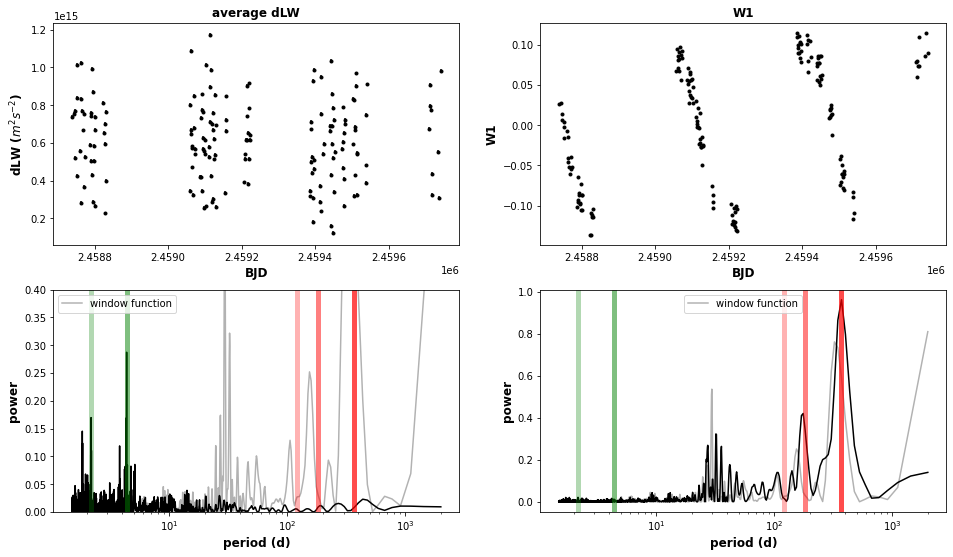

In [24]:
## Both figures 
wf = np.ones(len(time_grid))

fig, ax = plt.subplots(2, 2, figsize=(16,9))

ax[0, 0].errorbar(time_grid, d2v_0, yerr=std_d2v_0, fmt='.k')
ax[0, 0].set_ylabel("dLW ($m^2 s^{-2}$)", size=12, weight='bold')
ax[0, 0].set_xlabel("BJD", size=12, weight='bold')
ax[0, 0].set_title("average dLW", size=12, weight='bold')

frequency, power = LombScargle(time_grid, wf, fit_mean=False, center_data=False).autopower(minimum_frequency=0.0005, maximum_frequency=1/1.5) #nyquist_factor=15)
ax[1, 0].plot(1/frequency, power, 'k', label='window function', alpha=0.3)
frequency, power = LombScargle(time_grid, d2v_0).autopower(minimum_frequency=1/2000, maximum_frequency=1/1.5)
ax[1, 0].plot(1/frequency, power, 'k')
ax[1, 0].set_ylabel("power", size=12, weight='bold')
ax[1, 0].set_xlabel("period (d)", size=12, weight='bold')
ax[1, 0].set_xscale('log')
ax[1, 0].axvline(365.25, color='r', alpha=0.7, linewidth=5)
ax[1, 0].axvline(365.25/2, color='r', alpha=0.5, linewidth=5)
ax[1, 0].axvline(365.25/3, color='r', alpha=0.3, linewidth=5)
ax[1, 0].axvline(Prot, color='g', alpha=0.5, linewidth=5)
ax[1, 0].axvline(Prot/2, color='g', alpha=0.3, linewidth=5)
ax[1, 0].set_ylim(0,0.4)
ax[1, 0].legend()

ax[0, 1].plot(time_grid, pca_d2v.components_[0], 'k.')
ax[0, 1].set_ylabel('W1', size=12, weight='bold')
ax[0, 1].set_xlabel("BJD", size=12, weight='bold')
ax[0, 1].set_title("W1", size=12, weight='bold')

frequency, power = LombScargle(time_grid, wf, fit_mean=False, center_data=False).autopower(minimum_frequency=0.0005, maximum_frequency=1/1.5) #nyquist_factor=15)
ax[1, 1].plot(1/frequency, power, 'k', label='window function', alpha=0.3)
frequency, power = LombScargle(time_grid, pca_d2v.components_[0]).autopower(minimum_frequency=1/2000, maximum_frequency=1/1.5)
ax[1, 1].plot(1/frequency, power, 'k')
ax[1, 1].set_ylabel("power", size=12, weight='bold')
ax[1, 1].set_xscale('log')
ax[1, 1].axvline(365.25, color='r', alpha=0.7, linewidth=5)
ax[1, 1].axvline(365.25/2, color='r', alpha=0.5, linewidth=5)
ax[1, 1].axvline(365.25/3, color='r', alpha=0.3, linewidth=5)
ax[1, 1].axvline(Prot, color='g', alpha=0.5, linewidth=5)
ax[1, 1].axvline(Prot/2, color='g', alpha=0.3, linewidth=5)
ax[1, 1].set_xlabel("period (d)", size=12, weight='bold')
ax[1, 1].legend()
plt.savefig("/media/paul/One Touch11/Paper1/" + target + "_ToyModel_overall.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [25]:
print(pearsonr(GP, d2v_0))
print(pearsonr(GP, pca_d2v.components_[0]))

(0.6916869750610795, 3.0579738948934627e-25)
(-0.17459717290226293, 0.023601356767923503)


## Run SPCAndie

In [26]:
period_grid = np.logspace(np.log(1.1), 3, 1000)
new_freq = 1/period_grid
frequency = new_freq # periodogram frequency grid

def periodo(ind, X, dX, t, show = False):
    t, dlw, sdlw = popnan(ind, X, dX, t)
    ls = LombScargle(t, dlw, sdlw)#.autopower(minimum_frequency=0.0005, maximum_frequency=1/1.5)
    power = ls.power(frequency)
    max_freq = frequency[np.argmax(power)]
    max_pow = np.max(power)
    max_fap = -np.log(ls.false_alarm_probability(max_pow))
    return(power, 1/max_freq, max_pow, max_fap)

def popnan(ind, X, dX, t):
    Xout = X[ind, np.invert(np.isnan(X[ind]))]
    tout = t[np.invert(np.isnan(X[ind]))]
    dXout = dX[ind, np.invert(np.isnan(X[ind]))]
    return(tout, Xout, dXout)

def PacMapDisp(X, n_neighbors=10, MN_rate=0.5, FP_rate=2.0):
    random.seed(110)
    X = X.reshape(X.shape[0], -1)
    # Initialize the pacmap instance
    # Setting n_neighbors to "None" leads to an automatic parameter selection
    # choice shown in "parameter" section of the README file.
    # Notice that from v0.6.0 on, we rename the n_dims parameter to n_components.
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=n_neighbors, MN_ratio=MN_rate, FP_ratio=FP_rate, random_state = 110, apply_pca = True)
    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(X, init="pca")
    # visualize the embedding
    fig = plt.figure(figsize=(16,10))
    scatter = plt.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="nipy_spectral", c=mf, s=10*mfap, norm=matplotlib.colors.LogNorm())
    cb = plt.colorbar(label='Period [d]')
    cb.set_label(label='Period [d]', size='large', weight='bold')
    cb.ax.tick_params(labelsize='large')
    handles, labels = scatter.legend_elements(prop='sizes', alpha = 0.6)
    #print(handles)
    #labels = [float(labels[i]) for i in range(len(labels))]
    #labels = np.sqrt(labels)/25
    #labels = [str(labels[i]) for i in range(len(labels))]
    plt.legend(handles, labels, title = '$- 10 logFAP_{max}$', prop={'size':12, 'weight':'bold'})
 
    plt.axis('off')
    plt.savefig("/media/paul/One Touch11/Paper1/" + target + "_Simu_PacMap.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    return(X_transformed)

100%|██████████| 15000/15000 [01:20<00:00, 185.87it/s]
/home/paul/.local/lib/python3.8/site-packages/pacmap/pacmap.py:774: UserWarning: Warning: random state is set to 110
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


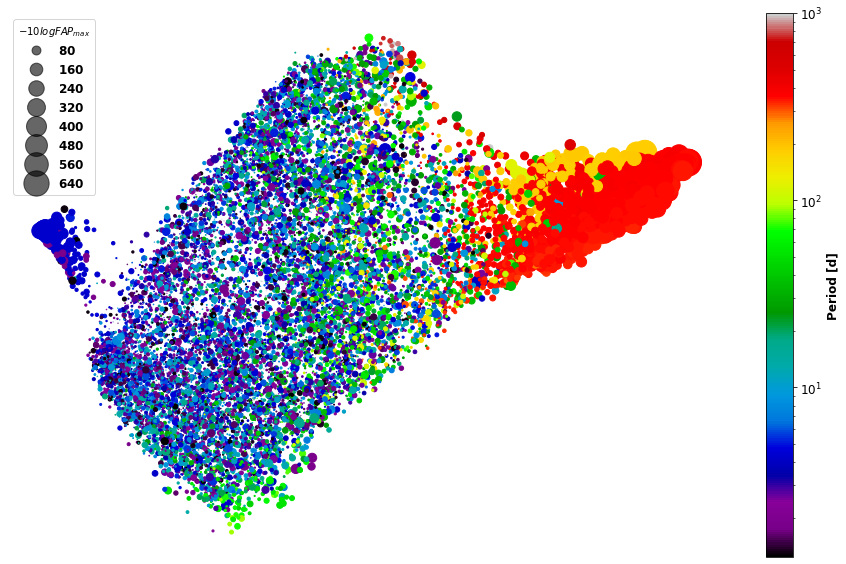

In [27]:
# Record every periodograms
powers = []
mf = []
mp = []
mfap = []
for i in tqdm(range(D2V_all.shape[0])):
    p, m, mmp, f  = periodo(i, D2V_all, sD2V_all, time_grid) 
    powers.append(p)
    mf.append(m)
    mp.append(mmp)
    mfap.append(f)
powers = np.array(powers)
mf = np.array(mf)
mp = np.array(mp)
mfap = np.array(mfap)


# Run clustering
PacMap_map = PacMapDisp(powers)

In [28]:
def select_per(Per, mxfq):
    U = Per * 0.05
    indlw = []
    for i in range(len(mxfq)):
        if mxfq[i]>Per-U and mxfq[i]<Per+U:
            indlw.append(i)
    return(indlw)

an = 365.25

Pac_an_1  = PacMap_map[select_per(an, mf)]
sample_weight_an_1 = mp[select_per(an, mf)]
size_an_1 = mfap[select_per(an, mf)]
Pac_an_2  = PacMap_map[select_per(an/2, mf)]
sample_weight_an_2 = mp[select_per(an/2, mf)]
size_an_2 = mfap[select_per(an/2, mf)]
Pac_an_3  = PacMap_map[select_per(an/3, mf)]
sample_weight_an_3 = mp[select_per(an/3, mf)]
size_an_3 = mfap[select_per(an/3, mf)]
#Pac_an_4  = PacMap_map[select_per(an/4, mf)]
Pac_prot_1  = PacMap_map[select_per(Prot, mf)]
sample_weight_prot_1 = mp[select_per(Prot, mf)]
size_prot_1 = mfap[select_per(Prot, mf)]
Pac_prot_2  = PacMap_map[select_per(Prot/2, mf)]
sample_weight_prot_2 = mp[select_per(Prot/2, mf)]
size_prot_2 = mfap[select_per(Prot/2, mf)]
#Pac_moon  = PacMap_map[select_per(28, mf)]
#Pac_70 = PacMap_map[select_per(an/5, mf)]

Pac_prot = np.concatenate((Pac_prot_1, Pac_prot_2))
sample_weight_prot = np.concatenate((sample_weight_prot_1, sample_weight_prot_2))
size_prot = np.concatenate((size_prot_1, size_prot_2))
Pac_an   = np.concatenate((Pac_an_1, Pac_an_2, Pac_an_3))
sample_weight_an = np.concatenate((sample_weight_an_1, sample_weight_an_2, sample_weight_an_3))
size_an   = np.concatenate((size_an_1, size_an_2, size_an_3))

print(Pac_prot.shape)
print(Pac_an.shape)
weight_ratio = Pac_an.shape[0]/Pac_prot.shape[0]

class_id = np.concatenate((np.zeros_like(Pac_prot.T[0]), np.ones_like(Pac_an.T[0])))
Pac_split = np.concatenate((Pac_prot, Pac_an))
sample_weight = np.concatenate((sample_weight_prot*weight_ratio, sample_weight_an))
size_split = np.concatenate((size_prot*weight_ratio, size_an))

(941, 2)
(1237, 2)


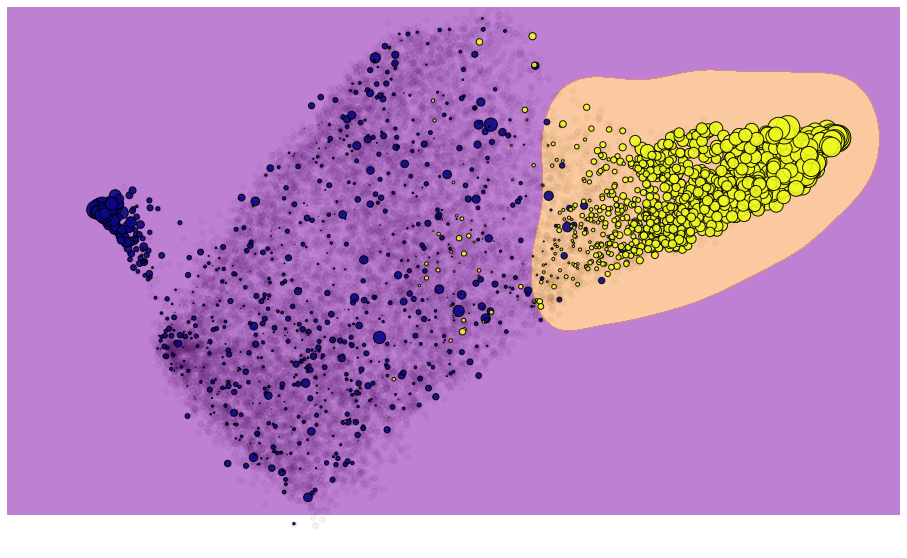

In [29]:
def plot_decision_function(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(-13, 17, 500), np.linspace(-6, 6, 500))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, levels=0, alpha=0.5, cmap=plt.cm.plasma)
    axis.scatter(
        Pac_split[:, 0],
        Pac_split[:, 1],
        c=class_id,
        s=10 * size_split,
        alpha=0.9,
        cmap=plt.cm.plasma,
        edgecolors="black",
    )

    axis.axis("off")
    #axis.set_title(title)
    
# Fit the models.

# This model does not take into account sample weights.
clf_no_weights = svm.SVC(kernel='rbf', gamma='auto')
clf_no_weights.fit(Pac_split, class_id)

# This other model takes into account some dedicated sample weights.
clf_weights = svm.SVC(kernel='rbf', gamma='auto')
clf_weights.fit(Pac_split, class_id, sample_weight=sample_weight)


fig, axes = plt.subplots(1, 1, figsize=(16, 10))
#plot_decision_function(
 #   clf_no_weights, np.ones(len(Pac_split))/3, axes[0], "Constant weights"
#)
axes.scatter(PacMap_map[:,0], PacMap_map[:,1], c='k', alpha = 0.05)
plot_decision_function(clf_weights, sample_weight, axes, "Modified weights 1:1")
plt.savefig("/media/paul/One Touch11/Paper1/" +target + "_Toy_modiW2.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Attribute a class for every lines

no_weights_predi = clf_no_weights.predict(PacMap_map)
weights_predi = clf_weights.predict(PacMap_map)


In [30]:
## Select only activity class data
dlw_filtr  = D2V_all[weights_predi == 0]
sdlw_filtr = sD2V_all[weights_predi == 0]
print(dlw_filtr.shape)

# Create masked arrays for the used RVs and RV uncertainties, masking any NaN values
ma_d2vs = np.ma.MaskedArray((dlw_filtr), mask=np.isnan((dlw_filtr)))
ma_dd2vs = np.ma.MaskedArray((sdlw_filtr), mask=np.isnan((sdlw_filtr)))

# Compute the average and variance of the used RVs and RV uncertainties using the masked arrays
average = np.ma.average(ma_d2vs, weights=1/ma_dd2vs**2, axis=1)
variance = np.ma.average((ma_d2vs-average.reshape(-1, 1))**2, weights=1/ma_dd2vs**2, axis=1)

# Reshape the averages and standard deviations into column vectors
mean_d2vs = average.data.reshape(-1, 1)
std_d2vs = np.sqrt(variance.data.reshape(-1, 1))

# Normalize the used RVs and RV uncertainties
RV2 = (np.copy(dlw_filtr)-mean_d2vs)/std_d2vs
dRV2 = np.copy(sdlw_filtr)/std_d2vs

weights = 1. / dRV2 # Not a mistake - The wPCA is coded in a way that 1/dX as a weights variable here means using 1/dX² as an effective weights
weights[np.isnan(RV2)] = 0
pca_filtr = WPCA(n_components=RV2.shape[1])
pca_filtr.fit(RV2, weights=weights)

(13080, 168)


WPCA(n_components=168)

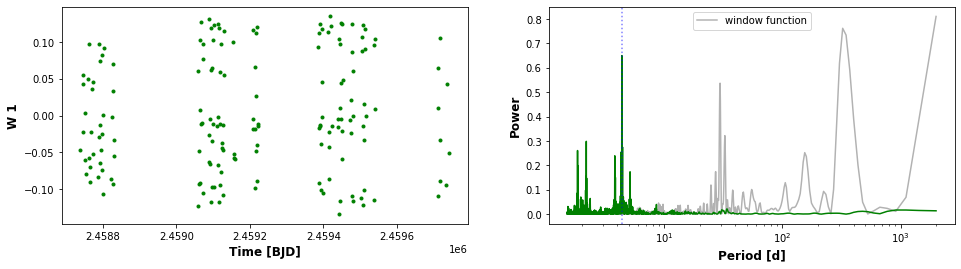

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

ax[0].plot(time_grid, pca_filtr.components_[0], 'g.')
ax[0].set_ylabel(f'W {1}', size=12, weight='bold')
# Set the x-axis label
ax[0].set_xlabel('Time [BJD]', size=12, weight='bold')


frequency, power = LombScargle(time_grid, wf, fit_mean=False, center_data=False).autopower(minimum_frequency=0.0005, maximum_frequency=1/1.5) #nyquist_factor=15)
ax[1].plot(1/frequency, power, 'k', label='window function', alpha=0.3)
frequency, power = LombScargle(time_grid, pca_filtr.components_[0]).autopower(minimum_frequency=1/2000, maximum_frequency=1/1.5)
ax[1].plot(1/frequency, power, 'g')
ax[1].set_ylabel("power")
ax[1].set_xscale('log')
ax[1].axvline(Prot, linestyle=':', color='b', alpha=0.5)
ax[1].set_xlabel('Period [d]', size=12, weight='bold')
ax[1].set_ylabel('Power', size=12, weight='bold')
plt.legend()
plt.savefig("/media/paul/One Touch11/Paper1/" + target + "_Simu_after.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [32]:
print(pearsonr(GP, pca_filtr.components_[0]))

(-0.9865814789062298, 1.3783013285661467e-132)


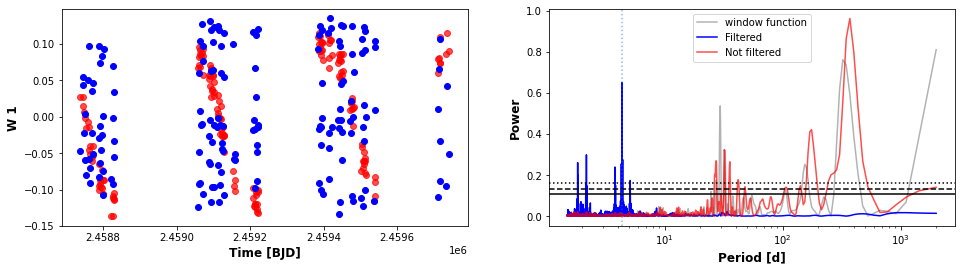

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].plot(time_grid, pca_d2v.components_[0], 'ro', alpha=0.7)
ax[0].plot(time_grid, pca_filtr.components_[0], 'bo')
ax[0].set_ylabel(f'W {1}', size=12, weight='bold')
# St the x-axis label
ax[0].set_xlabel('Time [BJD]', size=12, weight='bold')

frequency, power = LombScargle(time_grid, wf, fit_mean=False, center_data=False).autopower(minimum_frequency=0.0005, maximum_frequency=1/1.5) #nyquist_factor=15)
ax[1].plot(1/frequency, power, 'k', label='window function', alpha=0.3)
frequency, power = LombScargle(time_grid, pca_filtr.components_[0]).autopower(minimum_frequency=0.0005, maximum_frequency=1/1.5) #nyquist_factor=15)
ax[1].plot(1/frequency, power, 'b', label='Filtered')
frequency, power = LombScargle(time_grid, pca_d2v.components_[0]).autopower(minimum_frequency=0.0005, maximum_frequency=1/1.5) #nyquist_factor=15)
ax[1].plot(1/frequency, power, 'r', alpha=0.7, label='Not filtered')
ax[1].set_ylabel("power")
ax[1].set_xscale('log')
ls = LombScargle(time_grid, pca_filtr.components_[0])
fap = ls.false_alarm_level(0.1)
ax[1].axhline(fap, linestyle='-', color='k')
fap = ls.false_alarm_level(0.01)
ax[1].axhline(fap, linestyle='--', color='k')
fap = ls.false_alarm_level(0.001)
ax[1].axhline(fap, linestyle=':', color='k')
ax[1].axvline(Prot, linestyle=':', alpha=0.5)
ax[1].set_xlabel('Period [d]', size=12, weight='bold')
ax[1].set_ylabel('Power', size=12, weight='bold')
ax[1].legend()

plt.savefig("/media/paul/One Touch11/Paper1/" + target + "_Simuba.pdf", format="pdf", bbox_inches="tight")

In [34]:
d2v_0_f, std_d2v_0_f = [], []
for idx in tqdm(range(len(time_grid)), leave=False):
    d2v_temp, std_d2v_temp = odd_ratio_mean(D2V_all[:,idx], sD2V_all[:,idx])
    d2v_0_f.append(d2v_temp)
    std_d2v_0_f.append(std_d2v_temp)
    
d2v_0_f, std_d2v_0_f = np.array(d2v_0_f), np.array(std_d2v_0_f)

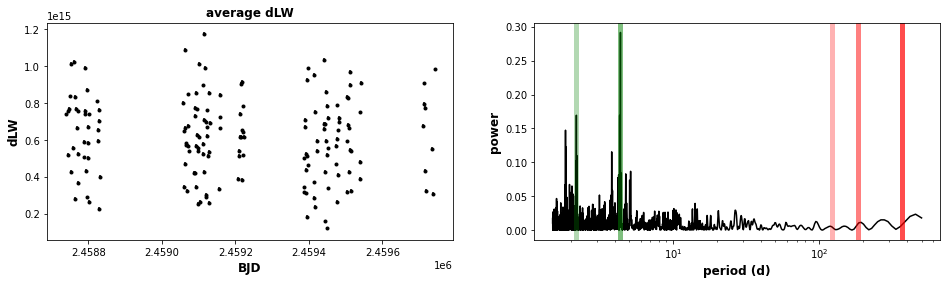

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

ax[0].errorbar(time_grid, d2v_0_f, yerr=std_d2v_0_f, fmt='.k')
ax[0].set_ylabel("dLW", size=12, weight='bold')
ax[0].set_xlabel("BJD", size=12, weight='bold')
ax[0].set_title("average dLW", size=12, weight='bold')

frequency, power = LombScargle(time_grid, d2v_0_f).autopower(minimum_frequency=1/500, maximum_frequency=1/1.5)
ax[1].plot(1/frequency, power, 'k')
ax[1].set_ylabel("power", size=12, weight='bold')
ax[1].set_xlabel("period (d)", size=12, weight='bold')
ax[1].set_xscale('log')
ax[1].axvline(365.25, color='r', alpha=0.7, linewidth=5)
ax[1].axvline(365.25/2, color='r', alpha=0.5, linewidth=5)
ax[1].axvline(365.25/3, color='r', alpha=0.3, linewidth=5)
ax[1].axvline(Prot, color='g', alpha=0.5, linewidth=5)
ax[1].axvline(Prot/2, color='g', alpha=0.3, linewidth=5)

In [36]:
print(pearsonr(GP, d2v_0_f))

(0.6916869750610795, 3.0579738948934627e-25)
